# Classification of cats based on their meows

In [1]:
import librosa
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import random
from sklearn import tree

## Define procedures

### 1. Extracting features from audio file used later for classification

In [2]:
def extract_features_from_waveform(data, sr):
    """
    Extracts features from a raw audio waveform.
    """
    # Extract MFCCs
    mfccs = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=13).mean(axis=1)

    # Extract Chroma features
    chroma = librosa.feature.chroma_stft(y=data, sr=sr).mean(axis=1)

    # Extract Spectral Contrast
    spectral_contrast = librosa.feature.spectral_contrast(y=data, sr=sr).mean(axis=1)

    # Combine all features
    return np.hstack([mfccs, chroma, spectral_contrast])

In [3]:
def cleanse_audio(file_path, target_sample_rate=16000):
    """
    Cleanses the audio file by performing the following:
    - Resampling to the target sample rate
    - Normalization
    - Trimming silence
    """
    # Load audio file
    data, sr = librosa.load(file_path, sr=None)

    # Trim silence from the beginning and end
    data, _ = librosa.effects.trim(data)

    # Resample to the target sample rate
    if sr != target_sample_rate:
        data = librosa.resample(data, orig_sr=sr, target_sr=target_sample_rate)
        sr = target_sample_rate

    # Normalize the audio to range [-1, 1]
    data = librosa.util.normalize(data)

    return data, sr

In [4]:
def check_ratio(data, target):
    count = 0
    for i in data:
        if i == target:
            count += 1
    return (count / len(data))
    

In [5]:
def divide_X_y(df):
    X_features = np.array(df['features'].tolist())
    
    context_encoder = LabelEncoder()
    breed_encoder = LabelEncoder()
    sex_encoder = LabelEncoder()
    
    # Transform the categorical columns into integers
    df['emission_context_encoded'] = context_encoder.fit_transform(df['emission_context'])
    df['breed_encoded'] = breed_encoder.fit_transform(df['breed'])
    
    # Extract the encoded columns as arrays
    X_context = df['emission_context_encoded'].to_numpy().reshape(-1, 1)
    X_breed = df['breed_encoded'].to_numpy().reshape(-1, 1)
    cat_id = df['cat_id'].to_numpy().reshape(-1, 1)
    # Combine features with the encoded categorical data
    X_combined = np.hstack([X_features, X_context, X_breed, cat_id])
    
    y = sex_encoder.fit_transform(df['sex'])  # Encode labels (sex)
    return X_combined, y, context_encoder, breed_encoder, sex_encoder

In [6]:
def split_data(X_combined, y, by_cat_id: bool = False, make_random: bool = False):
    state = 42
    if make_random:
        np.random.shuffle(X_combined)
    if not by_cat_id:
        X_train, X_temp, y_train, y_temp = train_test_split(X_combined, y, test_size=0.3, random_state=state)
        X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=state)
    else:
        perfect_num_for_test = 0.3 * len(X_combined)
        num_for_test = 0
        X_train_val = []
        y_train_val = []
        i = 0
        seen_ids = set()
        current_id = ""
        while num_for_test < perfect_num_for_test:  
            for cat in X_combined:
                if cat[-1] not in seen_ids:
                    seen_ids.add(cat[-1])
                    current_id = cat[-1]
                    break
            for cat, i in zip(X_combined, y):
                cat_id = cat[-1]
                if cat_id == current_id:
                    X_train_val.append(cat)
                    y_train_val.append(i)
                    num_for_test += 1
        X_train = []
        y_train = []
        for cat, i in zip(X_combined, y):
            if cat[-1] not in seen_ids:
                X_train.append(cat)
                y_train.append(i)
        X_val, X_test, y_val, y_test = train_test_split(X_train_val, y_train_val, test_size=0.5, random_state=state)
        
        X_train = np.array(X_train)
        X_val = np.array(X_val)
        X_test = np.array(X_test)
        y_train = np.array(y_train)
        y_val = np.array(y_val)
        y_test = np.array(y_test)
    return X_train, y_train, X_val, y_val, X_test, y_test

## Preprocess data
### Since male meows are undersampled I will augment the data by duplicating every male sample with changed pitch

In [7]:
DATA_DIR = "../dataanalysis/dataset/dataset/"
audio_files = os.listdir(DATA_DIR)

count_male = 0
count_all = 0
data = []
count_files = len(audio_files)
for file in audio_files:
    count_all += 1
    split = file.split('_')
    label_context = split[0]
    cat_id = split[1]
    label_breed = split[2]
    # label_sex = split[3]   # 4 classes
    label_sex = split[3][0]  # 2 classes
    file_path = os.path.join(DATA_DIR, file)

    # Load and cleanse audio
    audio_data, sr = cleanse_audio(file_path)

    # Extract features for the original audio
    features = extract_features_from_waveform(audio_data, sr)
    data.append([features, label_context, label_breed, label_sex, cat_id])

    # Augment male cat data
    #if label_sex in ['MI', 'MN']:
    if label_sex == 'M':
        count_all += 2
        count_male += 3
        # Apply pitch shifting
        data_shifted = librosa.effects.pitch_shift(audio_data, sr=sr, n_steps=2)
        features_shifted = extract_features_from_waveform(data_shifted, sr)
        time_stretched = librosa.effects.time_stretch(audio_data, rate=1.1) 
        features_stretched = extract_features_from_waveform(time_stretched, sr)
        data.append([features_shifted, label_context, label_breed, label_sex, cat_id + 'A1'])
        data.append([features_stretched, label_context, label_breed, label_sex, cat_id + 'A2'])

df = pd.DataFrame(data, columns=['features', 'emission_context', 'breed', 'sex', 'cat_id'])

### Now this is the % of male samples

In [8]:
count_male/count_all

0.4523809523809524

In [9]:
X_combined, y, context_encoder, breed_encoder, sex_encoder = divide_X_y(df)

In [10]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X_combined, y, by_cat_id=True, make_random=True)

In [11]:
check_ratio(y_train, sex_encoder.transform(['F']))

0.5460992907801419

In [12]:
check_ratio(y_test, sex_encoder.transform(['F']))

0.5384615384615384

In [13]:
check_ratio(y_val, sex_encoder.transform(['F']))

0.5631067961165048

### Remove sex label from data and scale it

In [14]:
X_train = X_train[:, :-1]
X_val = X_val[:, :-1]
X_test = X_test[:, :-1]

In [15]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

Used for classifiers without division for validation and testing

In [16]:
X_tv = np.concatenate((X_test, X_val))
y_tv = np.concatenate((y_test, y_val))

## Neural Network with 2 hiden layers - 128 and 64 nodes

In [17]:
model = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),  # Input layer
    layers.Dense(128, activation='relu'),  # Fully connected layer
    layers.Dropout(0.3),  # Dropout to prevent overfitting
    layers.Dense(64, activation='relu'),  # Second dense layer
    layers.Dropout(0.3),
    layers.Dense(len(np.unique(y)), activation='softmax')  # Output layer with softmax for classification
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               4480      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 2)                 130       
                                                                 
Total params: 12866 (50.26 KB)
Trainable params: 12866 (50.26 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [31]:
# Define early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,  # Stop training if validation loss doesn't improve for 5 epochs
    restore_best_weights=True
)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[early_stopping]
)

Epoch 1/100
7/7 [==============================] - 0s 14ms/step - loss: 0.7146 - accuracy: 0.5296 - val_loss: 0.7089 - val_accuracy: 0.5340
Epoch 2/100
7/7 [==============================] - 0s 11ms/step - loss: 0.7055 - accuracy: 0.5768 - val_loss: 0.7236 - val_accuracy: 0.4369
Epoch 3/100
7/7 [==============================] - 0s 8ms/step - loss: 0.6990 - accuracy: 0.5414 - val_loss: 0.7342 - val_accuracy: 0.3981
Epoch 4/100
7/7 [==============================] - 0s 6ms/step - loss: 0.6827 - accuracy: 0.5981 - val_loss: 0.7362 - val_accuracy: 0.4175
Epoch 5/100
7/7 [==============================] - 0s 6ms/step - loss: 0.6892 - accuracy: 0.6005 - val_loss: 0.7388 - val_accuracy: 0.4078
Epoch 6/100
7/7 [==============================] - 0s 6ms/step - loss: 0.6821 - accuracy: 0.6028 - val_loss: 0.7391 - val_accuracy: 0.4078


In [32]:
# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

4/4 [==============================] - 0s 2ms/step - loss: 0.7128 - accuracy: 0.4904
Test Loss: 0.7128
Test Accuracy: 0.4904


4/4 [==============================] - 0s 1ms/step


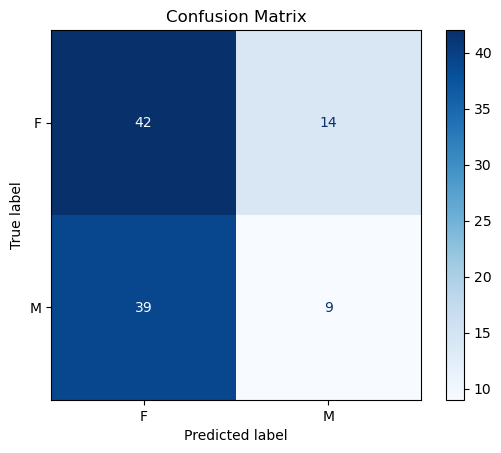

In [33]:
# Make predictions on the test set
y_pred_prob = model.predict(X_test)  # Output will be probabilities
y_pred = np.argmax(y_pred_prob, axis=1)  # Convert probabilities to class indices


# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sex_encoder.classes_)
disp.plot(cmap=plt.cm.Blues, values_format='d')  # 'd' for integer format
plt.title("Confusion Matrix")
plt.show()

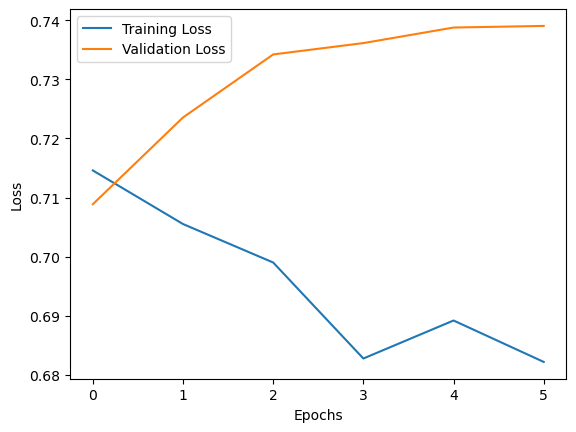

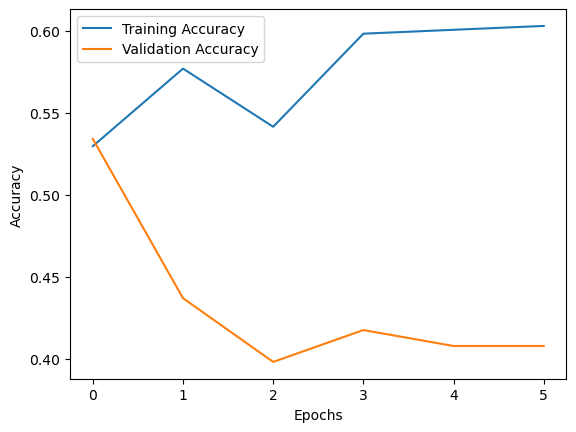

In [34]:
# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [35]:
def test_audio_files_from_directory_nn(directory: str, label_context: str = "", label_breed: str = ""):
    test_files = os.listdir(directory)
    predictions = []
    for file in test_files:
        split = file.split('_')
        if label_context == "":
            label_context = split[0]
        if label_breed == "":
            label_breed = split[2]
        file_path = os.path.join(directory, file)
        audio_data, sr = cleanse_audio(file_path)
        features = extract_features_from_waveform(audio_data, sr)
        
        X_features = np.array([features])
    
        encoded_context = context_encoder.transform([label_context])
        encoded_breed = breed_encoder.transform([label_breed])
        
        X_context = encoded_context.reshape(-1, 1)
        X_breed = encoded_breed.reshape(-1, 1)
        
        X_combined = np.hstack([X_features, X_context, X_breed])
        X_combined = scaler.transform(X_combined)
        
        prob_prediction = model.predict(X_combined)
        predictions.append(sex_encoder.inverse_transform(np.argmax(prob_prediction, axis=1))[0])
        
    return predictions

In [36]:
test_audio_files_from_directory_nn("../dataanalysis/dataset/testset/")

1/1 [==============================] - 0s 18ms/step


['F', 'F', 'F']

# Now lets use less advanced classifiers

In [37]:
def train(Classifier):
    global X_tv, y_tv, X_train, y_train
    Classifier.fit(X_train, y_train)
    correct = 0
    pred = Classifier.predict(X_train)
    for i in range(len(pred)):
        if pred[i] == y_train[i]:
            correct += 1
    train_acc = correct / len(y_train)
    pred = Classifier.predict(X_tv)
    correct = 0
    for i in range(len(pred)):
        if pred[i] == y_tv[i]:
            correct += 1
    test_acc = correct / len(y_tv)
    return Classifier, train_acc, test_acc

In [38]:
def test_audio_files_from_directory_classifier(directory: str, Classifier, label_context: str = "", label_breed: str = ""):
    test_files = os.listdir(directory)
    predictions = []
    for file in test_files:
        split = file.split('_')
        if label_context == "":
            label_context = split[0]
        if label_breed == "":
            label_breed = split[2]
        file_path = os.path.join(directory, file)
        audio_data, sr = cleanse_audio(file_path)
        features = extract_features_from_waveform(audio_data, sr)
        
        X_features = np.array([features])
    
        encoded_context = context_encoder.transform([label_context])
        encoded_breed = breed_encoder.transform([label_breed])
        
        X_context = encoded_context.reshape(-1, 1)
        X_breed = encoded_breed.reshape(-1, 1)
        
        X_combined = np.hstack([X_features, X_context, X_breed])
        X_combined = scaler.transform(X_combined)
        
        prediction = Classifier.predict(X_combined)
        predictions.append(sex_encoder.inverse_transform(prediction))
        
    return predictions

In [39]:
from sklearn.tree import DecisionTreeClassifier
dtc, train_acc, test_acc = train(DecisionTreeClassifier(random_state=0, max_depth=3, min_samples_split=10))
print(train_acc)
print(test_acc)


0.6382978723404256
0.5265700483091788


[Text(0.4090909090909091, 0.875, 'x[22] <= -1.398\ngini = 0.496\nsamples = 423\nvalue = [231, 192]'),
 Text(0.18181818181818182, 0.625, 'x[16] <= 2.064\ngini = 0.083\nsamples = 23\nvalue = [22, 1]'),
 Text(0.29545454545454547, 0.75, 'True  '),
 Text(0.09090909090909091, 0.375, 'gini = 0.0\nsamples = 22\nvalue = [22, 0]'),
 Text(0.2727272727272727, 0.375, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.6363636363636364, 0.625, 'x[4] <= -1.415\ngini = 0.499\nsamples = 400\nvalue = [209, 191]'),
 Text(0.5227272727272727, 0.75, '  False'),
 Text(0.45454545454545453, 0.375, 'x[17] <= 1.769\ngini = 0.399\nsamples = 40\nvalue = [11, 29]'),
 Text(0.36363636363636365, 0.125, 'gini = 0.339\nsamples = 37\nvalue = [8, 29]'),
 Text(0.5454545454545454, 0.125, 'gini = 0.0\nsamples = 3\nvalue = [3, 0]'),
 Text(0.8181818181818182, 0.375, 'x[5] <= -1.146\ngini = 0.495\nsamples = 360\nvalue = [198.0, 162.0]'),
 Text(0.7272727272727273, 0.125, 'gini = 0.435\nsamples = 47\nvalue = [15, 32]'),
 Text(0.9

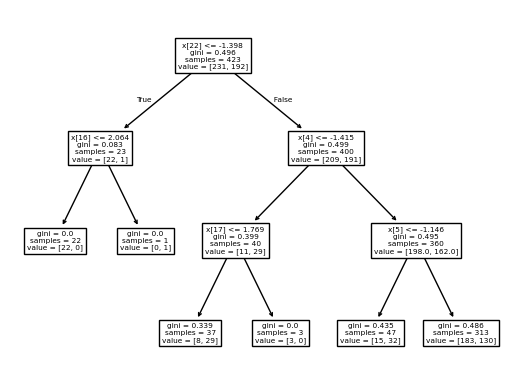

In [40]:
tree.plot_tree(dtc)

In [41]:
from sklearn.ensemble import RandomForestClassifier
rfc, train_acc, test_acc = train(RandomForestClassifier(max_depth=3, random_state=2))
print(train_acc)
print(test_acc)

0.7399527186761229
0.5265700483091788


In [42]:
test_audio_files_from_directory_classifier("../dataanalysis/dataset/testset/", rfc)

[array(['F'], dtype=object),
 array(['F'], dtype=object),
 array(['F'], dtype=object)]

In [43]:
test_audio_files_from_directory_classifier("../dataanalysis/dataset/testset/", dtc)

[array(['F'], dtype=object),
 array(['F'], dtype=object),
 array(['F'], dtype=object)]